In [ ]:
!pip install torch torchvision tqdm

In [ ]:
## SET LIBRARY

In [1]:
import os, time
from glob import glob
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## LOAD DATA

In [ ]:
#!pwd
#!gsutil cp gs://supark-sandbox/all.zip ./
#!unzip all.zip
#!unzip train.zip
#!mv train src

In [2]:
path = '/jet/prs/workspace/'

files = glob(os.path.join(path, 'data/*.jpg'))
print('Training Set size: {}'.format(len(files)))

Training Set size: 25000


In [3]:
idx_obs = np.random.permutation(len(files))

In [4]:
os.mkdir(os.path.join(path, 'train'))
os.mkdir(os.path.join(path, 'valid'))

In [5]:
for sub in ('train','valid'):
    for lbl in ('dog/','cat/'):
        os.mkdir(os.path.join(path, sub, lbl))

In [6]:
for i in idx_obs[2000:]:
    lbl = files[i].split('/')[-1].split('.')[0]
    img = files[i].split('/')[-1]
    os.rename(files[i], os.path.join(path, 'train', lbl, img))

In [7]:
for i in idx_obs[:2000]:
    lbl = files[i].split('/')[-1].split('.')[0]
    img = files[i].split('/')[-1]
    os.rename(files[i], os.path.join(path, 'valid', lbl, img))

In [8]:
for sub in ('train','valid'):
    for lbl in ('dog','cat'):
        print('{} {} size: {}'.format(sub,lbl,len(glob(os.path.join(path, sub, lbl, '*.jpg')))))

train dog size: 11535
train cat size: 11465
valid dog size: 965
valid cat size: 1035


In [44]:
# from torchvision import transforms
transform_fn = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(os.path.join(path,'train'), transform_fn)
valid = ImageFolder(os.path.join(path,'valid'), transform_fn)

In [45]:
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [46]:
def imshow(tnsr):
    tnsr = tnsr.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tnsr = std * tnsr + mean
    tnsr = np.clip(tnsr, 0, 1)
    plt.imshow(tnsr)

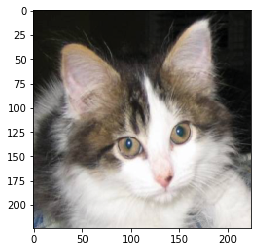

In [47]:
imshow(train[50][0])

In [48]:
g_train = DataLoader(train, batch_size=64, num_workers=3, shuffle=True)
g_valid = DataLoader(valid, batch_size=64, num_workers=3, shuffle=True)
dataloader = {'train': g_train, 'valid': g_valid}
dataset_sizes = {'train':len(g_train.dataset),'valid':len(g_valid.dataset)}

In [ ]:
## SET GRAPH

In [49]:
GPH = models.resnet18(pretrained=True)
num_ftrs = GPH.fc.in_features
GPH.fc = nn.Linear(num_ftrs, 2)

if torch.cuda.is_available():
    GPH = GPH.cuda()

In [ ]:
## TRAIN

In [15]:
learning_rate = 0.001
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(GPH.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [68]:
def do_train(gph, loss, optimizer, scheduler, num_epochs=1):
    bgn_tms = time.time()

    best_gph_wts = gph.state_dict()
    best_acc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ('train', 'valid'):
            if phase == 'train':
                scheduler.step()
                gph.train(True)
            else:
                gph.train(False)

            running_loss = 0.0
            running_corrects = 0
            running_counts = 0

            for data in dataloader[phase]:
                x_input, y_label = data

                if torch.cuda.is_available():
                    x_input = Variable(x_input.cuda())
                    y_label = Variable(y_label.cuda())
                else:
                    x_input, y_label = Variable(x_input), Variable(y_label)

                optimizer.zero_grad()

                y_prob = gph(x_input)
                _, y_pred = torch.max(y_prob, 1)
                loss = Loss(y_prob, y_label)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(y_pred == y_label.data).item()
                running_counts += len(y_pred)

            epoch_loss = running_loss / running_counts
            epoch_acc = running_corrects / running_counts
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_gph_wts = gph.state_dict()

        print()

    time_elapsed = time.time() - bgn_tms
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    gph.load_state_dict(best_gph_wts)
    return gph

In [69]:
gph = do_train(GPH, Loss, optimizer, scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.0139 Acc: 0.4356
valid Loss: 0.0142 Acc: 0.4270

Epoch 1/1
----------
train Loss: 0.0139 Acc: 0.4357
valid Loss: 0.0140 Acc: 0.4325

Training complete in 2m 12s
Best val Acc: 0.432500
